# Variational Autoencoder Formulation and Intuition

Blog post by: https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler

import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf


Using TensorFlow backend.


In [2]:
m = 50
n_z = 2
n_epoch = 10    

First, let’s implement the encoder net Q(z|X), which takes input X and outputting two things: μ(X) and Σ(X), the parameters of the Gaussian

In [3]:
# Q(z|X) -- encoder
inputs = Input(shape=(784,))
# h_q = Dense(512, activation='relu')(inputs)
# mu = Dense(n_z, activation='linear')(h_q)

# Make Encoder deeper: 
encoded = Dense(512, activation='relu')(inputs)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

# Q network outputs mu and log(sigma)
mu = Dense(n_z, activation='linear')(encoded)
log_sigma = Dense(n_z, activation='linear')(encoded)

That is, our Q(z|X) is a neural net with one (or many) hidden layer(s). In this implementation, our latent variable is two dimensional, so that we can easily visualize it.

The reparameterization trick is as follows. Recall, if we have $x∼N(μ,Σ)$ and then standardize it so that $μ=0,Σ=1$, we could revert it back to the original distribution by reverting the standardization process. Hence, we have this equation: $x=μ+Σ^\frac{1}{2} x_{std}$ 

With that in mind, we could extend it. If we sample from a standard normal distribution, we could convert it to any Gaussian we want if we know the mean and the variance. Hence we could implement our sampling operation of $z$ by: $z=μ(X)+Σ^\frac{1}{2}(X)\epsilon $, where $\epsilon∼N(0,1)$ .

In [4]:
def sample_z(args):
    (m, n_z) = 50, 2 
    
    mu, log_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2) * eps

# Sample z ~ Q(z|X)
z = Lambda(sample_z)([mu, log_sigma])


Now we create the decoder net $P(X|z)$:



In [5]:
# P(X|z) -- decoder
h1 = Dense(32, activation='relu')
h2 = Dense(64, activation='relu')
h3 = Dense(128, activation='relu')
decoder_out = Dense(784, activation='sigmoid')

h_p = h1(z)
h_p = h2(h_p)
h_p = h3(h_p)
outputs = decoder_out(h_p)


Lastly, from this model, we can do three things: reconstruct inputs, encode inputs into latent variables, and generate data from latent variable. So, we have three Keras models:
        

In [6]:
# ### NORMAL AE:

#     latent_dim = Input(shape=(2,))
#     decoded = Dense(64, activation='relu')(latent_dim)
#     decoded = Dense(128, activation='relu')(decoded)
#     decoded = Dense(784, activation='sigmoid')(decoded)
    
#     # decoder model
#     decoder = Model(latent_dim, decoded, name='dec')
    
    
# ## VAE Blog:

#     decoder_hidden = Dense(512, activation='relu')
#     decoder_out = Dense(784, activation='sigmoid')

#     h_p = decoder_hidden(z)
#     outputs = decoder_out(h_p)

#     d_h = decoder_hidden(d_in)
#     d_out = decoder_out(d_h)

#     decoder = Model(d_in, d_out)


In [7]:
# Overall VAE model, for reconstruction and training
vae = Model(inputs, outputs, name='vae')

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = Model(inputs, mu, name='enc')

# Generator model, generate new data given latent variable z
d_in = Input(shape=(n_z,))
d_h = h1(d_in)
d_h = h2(d_h)
d_h = h3(d_h)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out, name='dec')


Then, we need to translate our loss into Keras code:

In [8]:
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)

    return recon + kl



and then train it: (with mnist data)

In [9]:
# Visualise 10 test examples, and the decoded versions
def visualize(x_test, decoded_imgs=None):
    n = 10    # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [10]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
X_train, y_train = mnist.train.images, mnist.train.labels
X_test, y_test = mnist.test.images, mnist.test.labels

X_train.shape, X_test.shape, y_test.shape 

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


((55000, 784), (10000, 784), (10000, 10))

In [11]:
vae.compile(optimizer='adam', loss=vae_loss)
vae.fit(X_train, X_train, batch_size=m, epochs=30, validation_split=0.1)

Train on 49500 samples, validate on 5500 samples
Epoch 1/30
49500/49500 [==============================] - 6s 113us/step - loss: 522.6345 - val_loss: 430.2796
Epoch 2/30
49500/49500 [==============================] - 5s 104us/step - loss: 431.6260 - val_loss: 430.2779
Epoch 3/30
49500/49500 [==============================] - 5s 103us/step - loss: 431.6252 - val_loss: 430.2776
Epoch 4/30
49500/49500 [==============================] - 5s 104us/step - loss: 431.6250 - val_loss: 430.2774
Epoch 5/30
49500/49500 [==============================] - 5s 97us/step - loss: 431.6249 - val_loss: 430.2774
Epoch 6/30
49500/49500 [==============================] - 4s 84us/step - loss: 431.6249 - val_loss: 430.2773
Epoch 7/30
49500/49500 [==============================] - 4s 83us/step - loss: 431.6248 - val_loss: 430.2773
Epoch 8/30
49500/49500 [==============================] - 4s 91us/step - loss: 431.6248 - val_loss: 430.2773
Epoch 9/30
49500/49500 [==============================] - 5s 100us/step - l

In [13]:
encoded = encoder.predict(X_test, batch_size=m)
encoded.shape

(10000, 2)

Visualize the 2D Encoded variables

In [14]:
encoded

array([[ 8.3701685e-05, -4.8831105e-05],
       [ 8.8079832e-04, -3.0621886e-05],
       [-4.7341175e-04, -1.7967820e-04],
       ...,
       [ 2.0148419e-04, -1.1703372e-04],
       [ 2.1390431e-04,  2.2023916e-05],
       [ 1.0236260e-03, -1.3598800e-04]], dtype=float32)

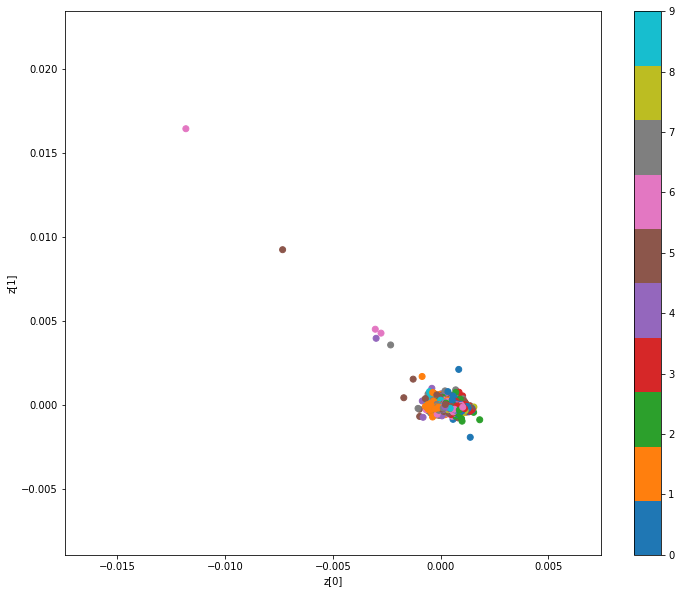

In [15]:
plt.figure(figsize=(12, 10))
plt.scatter(encoded[:, 0], encoded[:, 1], c=np.argmax(y_test, axis=1), cmap='tab10')
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

In [16]:
X_recons = vae.predict(X_test, batch_size=m)
# visualize(X_test_subset, X_recons)

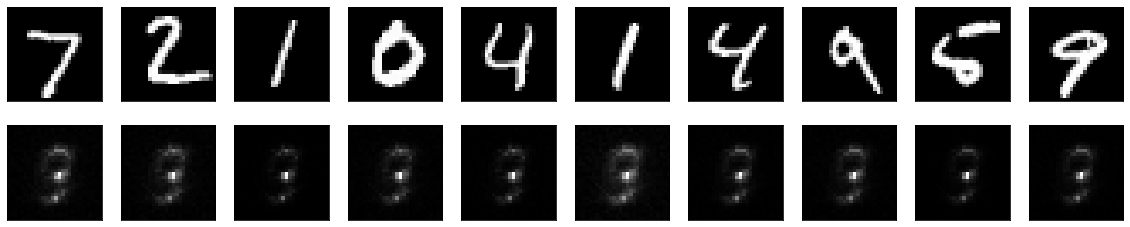

In [17]:
n = 10    # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_recons[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

[[ 0.2290336  -0.10181502]
 [-0.30255279 -1.63154503]
 [-0.72537246  0.41369429]
 [ 0.54900832  1.0527252 ]
 [ 2.12431362  1.55556259]
 [-1.4386442   1.3551553 ]
 [-0.19912464  1.62678737]
 [-1.45946284 -0.38434237]
 [-1.72436881 -1.47168184]
 [ 1.71907282 -1.03860621]]


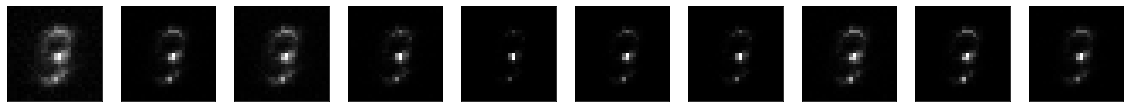

In [18]:
# Generating new samples from latent space; P(X|z,y) visualization
y_label = 1

z_sample = np.random.randn(n, n_z)
print(z_sample)

y = np.zeros(shape=(n, y_test.shape[0]))
y[:, y_label] = 1


X_gen = decoder.predict(z_sample)

plt.figure(figsize=(20, 4))

for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_gen[i-1].reshape(28, 28), cmap='Greys_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()